# Chapter 11 - Polars Readers 

In [1]:
import pyodbc
import sys
import polars as pl
import sqlalchemy as sa
from IPython.display import Image

Return the Python and panda version being used since the database library drivers need to be properly aligned.

In [2]:
print(f'Python version: {sys.version}')
print(f'polars version: {pl.__version__}')

Python version: 3.13.9 (tags/v3.13.9:8183fa5, Oct 14 2025, 14:09:13) [MSC v.1944 64 bit (AMD64)]
polars version: 1.32.0


## pd.read_csv(URL) method 

This notebook contains several examples of the pl.read_csv() method.  Additional examples are used in [Chapter 5-Polars (part 1)](05-Polars.ipynb), and 2 additional examples in [Chapter 8-Time Series and Date Handling](08-Time_Series_and_Date_Handling.ipynb).


The `pl.read_csv()` method accepts a range of file format types.  In the example below, a URL is given as the input source.  In the SAS example that follows, the FILENAME URL access method is utilized to the same effect.

In [3]:
fips = pl.read_csv(
    'http://www2.census.gov/geo/docs/reference/codes/files/national_county.txt',
    has_header=False,  # there is no header row
    new_columns=['state','state_fips','county_fips','county','fips_class_code'],  # use this column names
)
fips.shape

(3235, 5)

````
    /******************************************************/
    /* c11_read_csv_url_method.sas                        */
    /******************************************************/
    44       filename ctyfips url "http://www2.census.gov/geo/docs/reference/codes/files/national_c
    44     ! ounty.txt";
    45       
    46       data cnty_fips;
    47       length county_nm $ 40
    48              st_name $ 32 ;
    49       
    50          infile ctyfips dlm=',';
    51          input st_abrev $
    52                st_fips $
    53                cnty_fips $
    54                county_nm $
    55                ;
    56       
    57       st_name = fipnamel(st_fips);

````

## SQLAlchemy Under the Covers

Polars utilizes <a href="http://www.sqlalchemy.org/"> SQLAlchemy </a> as an abstraction layer when interacting with databases, reducing the amount of database-dependent code polars needs internally.

Using SQLAlchemy you can pass SQLAlchemy Expression language constructs which are database-agnostic.  This is analogous to PROC SQL's behavior of general SQL constructs being translated to specific a database without you having to know the specific SQL dialect.

Two parts needed.  You need the SQLAlchemy package (if you don't have it installed, run `pip install sqlalchemy`). 

The second is the driver library for the target database.  In my case, I am using MS SQL/Server. If you are using SQL Server, ensure that you have a relatively more recent driver like ODBC 18 (or, at least 17) Driver for SQL Server.  The target database used below is AdventureWorksDW2012 which Microsoft provides to illustrate their Analytical Services.

The examples are analogous to SAS' SQL pass-thru approach where PROC SQL is a wrapper to pass-thru the SQL dialect specific to the database.   

To connect to the database with SQLAlchemy, you construct a connection string to the database (uri) using the create_engine() method.  The SQLAlchemy doc for the various databases are <a href="http://docs.sqlalchemy.org/en/rel_1_1/core/connections.html"> here </a>. This only needs to be executed once for the connection shown as:

    ServerName = "homeoffice2"
    Database = "AdventureWorksDW2012?driver=SQL+Server+Native+Client+11.0"
    TableName = "DimCustomer"

    engine = create_engine('mssql+pyodbc://' + ServerName + '/' + Database, legacy_schema_aliasing=False)
    
The string:
 
  ?driver=SQL+Server+Native+Client+11.0
  
was needed to inform SQLAlchemy the name of the specific database client library.  This is found on the Driver's tab of the ODBC Data Source Adminstrator.

If you don't have SQL Server (or another database) available to trial, there's an included AdventureWorks in sqlite format I built which you can connect to to follow along.

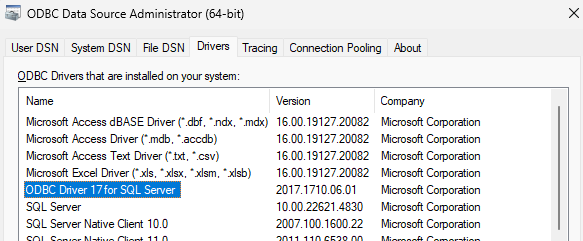

In [4]:
Image(filename='img/odbc.png')

Next, create a tuple of parameter values to pass to the create_engine= assignment to identify the Python package used on the client-side as well as the database server name, target database, and target table. 

## Find Your Connection Strings

* Use `sqlalchemy` to guide you: https://docs.sqlalchemy.org/en/20/core/engines.html

In [3]:
server_name = "homeoffice2"
database = "AdventureWorksDW2012"

eng = sa.create_engine(f'mssql+pyodbc://{server_name}/{database}?driver=SQL+Server+Native+Client+17.0')

In [5]:
db_path = 'data/AdventureWorks.sqlite.db'

eng = sa.create_engine(f'sqlite:///{db_path}')

## read_sql_table()

The read_sql_table() method reads a database table and optionally a subset of columns.  The syntax is documented <a href="http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html#pandas.read_sql_table"> here </a>.

For clarity, we build a <a href="http://nbviewer.jupyter.org/github/RandyBetancourt/PythonForSASUsers/blob/master/Chapter%2002%20--%20Data%20Structures.ipynb#list">list</a> of columns we want to have returned along with a table name that are used as arguments in the next set of examples.

In [6]:
table_name = 'Customer'

In [18]:
query = f'select * from {table_name};'
t0 = pl.read_database(query, eng)
t0.schema

Schema([('CustomerID', Int64),
        ('NameStyle', Int64),
        ('Title', String),
        ('FirstName', String),
        ('MiddleName', String),
        ('LastName', String),
        ('Suffix', String),
        ('CompanyName', String),
        ('SalesPerson', String),
        ('EmailAddress', String),
        ('Phone', String),
        ('PasswordHash', String),
        ('PasswordSalt', String),
        ('rowguid', String),
        ('ModifiedDate', String)])

In [8]:
t0.head()

CustomerID,NameStyle,Title,FirstName,MiddleName,LastName,Suffix,CompanyName,SalesPerson,EmailAddress,Phone,PasswordHash,PasswordSalt,rowguid,ModifiedDate
i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str
1,0,"""Mr.""","""Orlando""","""N.""","""Gee""",null,"""A Bike Store""","""adventure-works\pamela0""","""orlando0@adventure-works.com""","""245-555-0173""","""L/Rlwxzp4w7RWmEgXX+/A7cXaePEPc…","""1KjXYs4=""","""3F5AE95E-B87D-4AED-95B4-C3797A…","""2005-08-01 00:00:00.000"""
2,0,"""Mr.""","""Keith""",null,"""Harris""",null,"""Progressive Sports""","""adventure-works\david8""","""keith0@adventure-works.com""","""170-555-0127""","""YPdtRdvqeAhj6wyxEsFdshBDNXxkCX…","""fs1ZGhY=""","""E552F657-A9AF-4A7D-A645-C429D6…","""2006-08-01 00:00:00.000"""
3,0,"""Ms.""","""Donna""","""F.""","""Carreras""",null,"""Advanced Bike Components""","""adventure-works\jillian0""","""donna0@adventure-works.com""","""279-555-0130""","""LNoK27abGQo48gGue3EBV/UrlYSToV…","""YTNH5Rw=""","""130774B1-DB21-4EF3-98C8-C104BC…","""2005-09-01 00:00:00.000"""
4,0,"""Ms.""","""Janet""","""M.""","""Gates""",null,"""Modular Cycle Systems""","""adventure-works\jillian0""","""janet1@adventure-works.com""","""710-555-0173""","""ElzTpSNbUW1Ut+L5cWlfR7MF6nBZia…","""nm7D5e4=""","""FF862851-1DAA-4044-BE7C-3E8558…","""2006-07-01 00:00:00.000"""
5,0,"""Mr.""","""Lucy""",null,"""Harrington""",null,"""Metropolitan Sports Supply""","""adventure-works\shu0""","""lucy0@adventure-works.com""","""828-555-0186""","""KJqV15wsX3PG8TS5GSddp6LFFVdd3C…","""cNFKU4w=""","""83905BDC-6F5E-4F71-B162-C98DA0…","""2006-09-01 00:00:00.000"""


Coerce date strings into date objects.  The example below is redundant since the query engine was smart enough to determine t0['BirthDate'] is a date column.  This is shown by examining output from t0.info() call showing the column as type datetime64.

In [23]:
# we're reading sql server, which typically uses mill seconds, so we'll have to coerce the format after reading
t2 = t0.with_columns(
    pl.col('ModifiedDate').str.strptime(pl.Datetime('us'), format='%Y-%m-%d %H:%M:%S%.3f')
)

Review the incoming columns and their attributes.

In [24]:
t2.schema

Schema([('CustomerID', Int64),
        ('NameStyle', Int64),
        ('Title', String),
        ('FirstName', String),
        ('MiddleName', String),
        ('LastName', String),
        ('Suffix', String),
        ('CompanyName', String),
        ('SalesPerson', String),
        ('EmailAddress', String),
        ('Phone', String),
        ('PasswordHash', String),
        ('PasswordSalt', String),
        ('rowguid', String),
        ('ModifiedDate', Datetime(time_unit='us', time_zone=None))])

Display the first 5 rows for the the 'BirthDate' column.  Also notice above, from the .info() method how the t2['BirthDate'] column was read as datetime timestamps.

N.b., there is no 'BirthDate', let's look at email address

In [28]:
t2['EmailAddress'].head(5)

EmailAddress
str
"""orlando0@adventure-works.com"""
"""keith0@adventure-works.com"""
"""donna0@adventure-works.com"""
"""janet1@adventure-works.com"""
"""lucy0@adventure-works.com"""


The SAS program below reads the same input table from SQL/Server called DimCustomer.  Under the covers, SAS constructs the appropriate TSQL statements to retrieve rows and columns forming the SAS data set WORK.CUSTOMERS.

In this case, SAS reads the 'BirthDate' variable as a string.  The SAS/Access product line provide an array of SAS Data Set options to map data types between SAS and SQL/Server described<a href="https://support.sas.com/documentation/cdl/en/acreldb/63647/HTML/default/viewer.htm#a001405621.htm"> here</a>.  SAS/Access products are outside the scope of these examples.  

````
    /******************************************************/
    /* c11_pd.read_sql_table.sas                          */
    /******************************************************/
    4         proc pwencode in=XXXXXXXXX;
    {sas001}UG9yc2hjZSMx
    5         
    6         libname sqlsrvr odbc
    7                  uid=randy
    8                  pwd=XXXXXXXXXXXXXXXXXXXX
    9                  datasrc=mssql
    10                 bulkload=yes;
    11        
    12        proc sql;
    13           create table customers as
    14           select FirstName,
    15                  LastName,
    16                  BirthDate,
    17                  Gender,
    18                  YearlyIncome,
    19                  CustomerKey
    20           from sqlsrvr.DimCustomer;
    NOTE: Data set "WORK.customers" has 18484 observation(s) and 6 variable(s)
    21        quit;
    22        
    23        data _null_;
    24           set customers(obs=5);
    25        
    26        bdate = input(birthdate, yymmdd10.);
    27        bd_f = put(bdate, yydddd10.);
    28        
    29        put bd_f;

    1966-04-08
    1965-05-14
    1965-08-12
    1968-02-15
    1968-08-08
````

In [30]:
sql_str = '''SELECT
                    Name,
                    ProductNumber,
                    Color,
                    ListPrice,
                    StandardCost
             FROM Product  
             WHERE ListPrice > 500''' 

q2 = pl.read_database(sql_str, eng)
q2.schema

Schema([('Name', String),
        ('ProductNumber', String),
        ('Color', String),
        ('ListPrice', Float64),
        ('StandardCost', Float64)])

In [33]:
q2.null_count()

Name,ProductNumber,Color,ListPrice,StandardCost
u32,u32,u32,u32,u32
0,0,0,0,0


You can execute a query without returning a dataframe with eng.execute(). This is useful for queries that don’t return values, such as a DROP TABLE statement. 

In [21]:
eng.execute(sa.text('DROP TABLE dbo.df2'))

## DataFrame.write_database

Construct the DataFrame to load into SQL/Server.

In [34]:
df = pl.DataFrame({
    'temp': ['cold', 'warm', 'hot', 'cool', 'cool', 'cold'],
    'speed': ['slow', 'medium', 'fast', None, 'medium', 'slow'],
    'size': [None, 4, 9, None, 16, None],
    'height': [2., 5, 4, None, 44, 29],
    'power': [6., 7, None, 17, 21, 33],
    'age': [3., 9, 6, 89, 13, 17]
})

The .DataFrame.read_database method loads a target DBMS table with the rows and columns from a DataFrame.  The syntax is documented <a href="https://docs.pola.rs/api/python/stable/reference/api/polars.read_database.html"> here </a>.  The method has the chunksize= parameter where the default None writes all rows at once.  The doc does not specify how the writes take place, either through SQL INSERT statements or uses a bulk copy interface.

In [37]:
df.write_database('my_data', eng, if_table_exists='replace')

6

The analog SAS program to copy a SAS data set to the target DBMS is below.  Note the PROC PWENCODE used to encode strings to prevent passwords from being stored in clear text.  Also notice the LIBNAME option bulkload=yes.  This causes the load operation to go through the RDBMS' bulk load interface.

````
    /******************************************************/
    /* c11_DataFrame.to_sql.sas                           */
    /******************************************************/

    56       proc pwencode in=XXXXXXXXX;
    {sas001}UG9yc2hjZSMx
    57       
    58       libname sqlsrvr odbc
    59                uid=randy
    60                pwd=XXXXXXXXXXXXXXXXXXXX
    61                datasrc=mssql
    62                bulkload=yes;

    63       
    64       data sqlsrvr.tickets;
    65          set tickets;

   NOTE: 72 observations were read from "WORK.tickets"
   NOTE: Data set "SQLSRVR.tickets" has an unknown number of observation(s) and 5 variable(s)
   
````

## read_sas

As of this writing, polars does not have a read_sas method. Use `pyreadstat` (`pip install pyreadstat`) which will read sas7bdat and othe statistical input formats.

In [3]:

def read_sas(filename):
    import pyreadstat
    df, meta = pyreadstat.read_sas7bdat(path, output_format='polars')
    return df

In [ ]:
# I don't have access to such a file
df4 = read_sas('accident.sas7bdat')

In [ ]:
df4.schema

The following SAS program was used to create both a SAS data and a SAS transport SAS data set.  Both were created with Version: 3.2.2 of the WPS Workbench for Windows.  The SAS data DATA.COMPANY failed to be read with the pd.read_sas() method.  The SAS transport file was read correctly below.

````
    /******************************************************/
    /* c11_write_export_file.sas                          */
    /******************************************************/
     93       libname data 'c:\data';
     94       libname xptout xport "c:\data\company.xpt";
     95       
     96              data data.company;
     97                 input Name $ 1-25 Age 27-28 Gender $ 30;
     98                 datalines;
     99       
    100       Vincent, Martina          34 F
    101       Phillipon, Marie-Odile    28 F
    102       Gunter, Thomas            27 M
    103       Harbinger, Nicholas       36 M
    104       Benito, Gisela            32 F
    105       Rudelich, Herbert         39 M
    106       Sirignano, Emily          12 F
    107       Morrison, Michael         32 M
    108       ;;;;
    109       
    110       proc copy in = data
    111                 out = xptout;
    112       select company;

    NOTE: Member "DATA.COMPANY.DATA" (memtype=DATA) copied
    NOTE: 1 member copied
````

In [9]:
# I don't have access to such a file, but presumably thsi works
df6 = read_sas("company.xpt")

In [ ]:
df6.schema

## Resources

* <a href="https://docs.pola.rs/user-guide/io/">Polars IO User Guide</a>
* <a href="http://docs.sqlalchemy.org/en/rel_1_1/core/connections.html"> defining the create_engine() method </a> from the SQLAlchemy doc.

## Navigation

* [Next Chapter](11-Additional_Data_Wrangling.ipynb)
* [Return to Contents](00-Contents.ipynb)